In [4]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Read Data

In [5]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

## Model training: KNN

In [27]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Transform the columns into features: Using baseline transformers

In [7]:
columnas_disc = ["Age", "AnnualIncome"]
columnas_vect = ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), columnas_disc),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"), columnas_vect),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [9]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

### Grid Search con KNN 

In [38]:
search_params_knn = {
    'n_neighbors': [4, 5, 6],
    'p': [2, 3, 4, 5],
    'weights': ['distance', 'uniform']
}
knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, search_params_knn, cv=5, scoring='f1', n_jobs=-1)
knn_clf.fit(X_train, y_train)

best_knn_clf = knn_clf.best_estimator_
best_knn_clf

KNeighborsClassifier(n_neighbors=6, weights='distance')

In [39]:
pred = best_knn_clf.predict(X_train)

## Check Results

### Confusion matrix

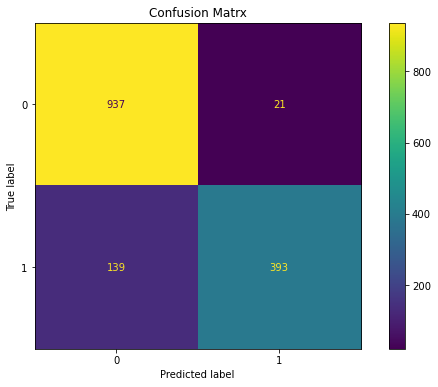

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(False)
ax.set_title('Confusion Matrx')

disp = plot_confusion_matrix(best_knn_clf, X_train, y_train, ax = ax)

### Clasification report

In [41]:
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       958
           1       0.95      0.74      0.83       532

    accuracy                           0.89      1490
   macro avg       0.91      0.86      0.88      1490
weighted avg       0.90      0.89      0.89      1490



## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [42]:
test_id = test_df["Customer"]
test_pred = best_knn_clf.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission.csv", header=True, index=False)